# Generated Data Experiment.

Generating fake data for $l_{max}=2$ to then fit the data for $l=1,2,3$, what we aim to show is that, for the $l=2$ least square fit we will recover the right parameters and the function will be at its mimimum, while when performing the least square fit for VSH function with $l=1$ and $l=3$ we will recover the dominant parmaters, however the function will not be at the minimum.

In [1]:
import jax 
import jax.numpy as jnp
import numpy as np
from src.models.vsh_model import*
import pandas as pd
from iminuit import Minuit # to perform least square
from src.models.configuration import*
from numpyro.infer import MCMC, NUTS
import numpyro
import numpyro.distributions as dist
from tqdm import tqdm
import gc

/root/Document/Gaia_Project/mem97/gaia_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load fake data

In [2]:
vsh_coeff_gen = np.load('fake_data/vsh_gen_cov.npy') # Load true coefficient values

fake_data = pd.read_csv('fake_data/fake_vsh_data.csv')
angles_gen, obs_gen, error_gen = config_data(fake_data)

### HMC

In [ ]:
def chi2_jit(angles, obs, error, theta, lmax):
    return least_square(angles, obs, error, theta, lmax=lmax, grid=False)
chi2_jit = jit(chi2_jit, static_argnames=['lmax'])


def model_for_HMC(angles, obs, error, lmax):
    total_params = count_vsh_coeffs(lmax)
    theta = numpyro.sample("theta", dist.Uniform(-0.08, 0.08).expand([total_params]))
    chi2_val = chi2_jit(angles, obs, error, theta, lmax) 
    numpyro.factor("likelihood", -0.5*chi2_val)

In [ ]:
posterior_samples = []
rng_key = jax.random.key(0)

kernel = NUTS(model_for_HMC, target_accept_prob=0.75)
mcmc = MCMC(kernel, num_warmup=100, num_samples=2000, num_chains=2, progress_bar=True)

for i in range(1,4):
    
    mcmc.run(rng_key, angles=angles_gen, obs=obs_gen, error=error_gen, lmax=i)
    posterior_sample = mcmc.get_samples()
    
    posterior_samples.append(posterior_sample)

Save results

In [ ]:
coef_pred = [jnp.mean(ps['theta'], axis=0) for ps in posterior_samples]
std_pred = [jnp.std(ps['theta'], axis=0) for ps in posterior_samples]

coef_pred_np = np.array([np.array(x) for x in coef_pred], dtype=object)
std_pred_np = np.array([np.array(x) for x in std_pred], dtype=object)

#np.savez('fake_data/posterior_summary.npz', coef=coef_pred_np, std=std_pred_np)


The above code takes a little while to run. One can instead load the saved results.

In [3]:
data = np.load('fake_data/posterior_summary.npz', allow_pickle=True)

coef_pred = [jnp.array(x) for x in data['coef']]
std_pred = [jnp.array(x) for x in data['std']]

### `iminuit.Minuit` Least-Square

In [4]:
def eval_loss(theta, lmax):
    return least_square(angles_gen, obs_gen, error_gen, theta, lmax=lmax, grid=False)
eval_loss = jit(eval_loss, static_argnames=['lmax'])

def run_iminuit(lmax, t_bound, s_bound):

    def least_square_wrapper(*theta_flat):
        theta = jnp.array(theta_flat)
        return float(eval_loss(theta, lmax)) 

    total_params = count_vsh_coeffs(lmax) 
    limits = vsh_minuit_limits(lmax, t_bound=t_bound, s_bound=s_bound)
    
    theta_init = jnp.zeros(total_params)    

    m = Minuit(least_square_wrapper, *theta_init)

    m.errordef = Minuit.LEAST_SQUARES
    for i, name in enumerate(m.parameters):
        m.limits[name] = limits[name]

    m.migrad()

    return m

In [5]:
fitted_thetas = []
std_theta_fit = []

for i in tqdm(range(1, 4), desc="Running Minuit fits"):

    m = run_iminuit(i, 0.08, 0.08)

    theta_fit = jnp.array([m.values[name] for name in m.parameters])
    fitted_thetas.append(theta_fit)
    std_theta_fit.append(jnp.sqrt(jnp.diag(m.covariance)))

    del m
    gc.collect()
    jax.clear_caches()


Running Minuit fits: 100%|██████████| 3/3 [00:36<00:00, 12.07s/it]


### Plot Results

We want to visualise the performance of a least-square fit compared to HMC sampling.

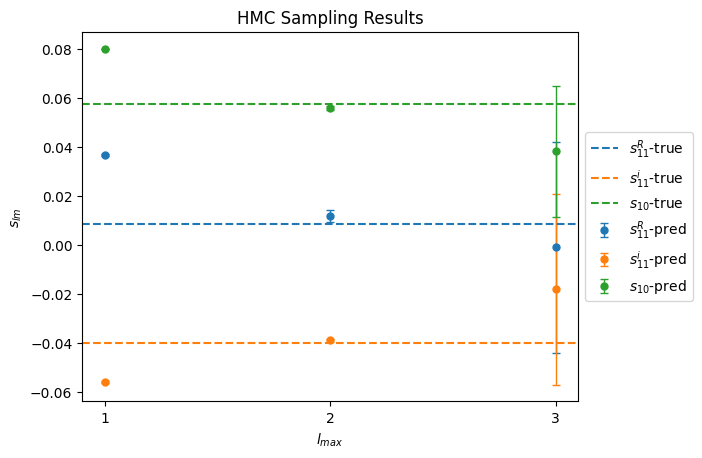

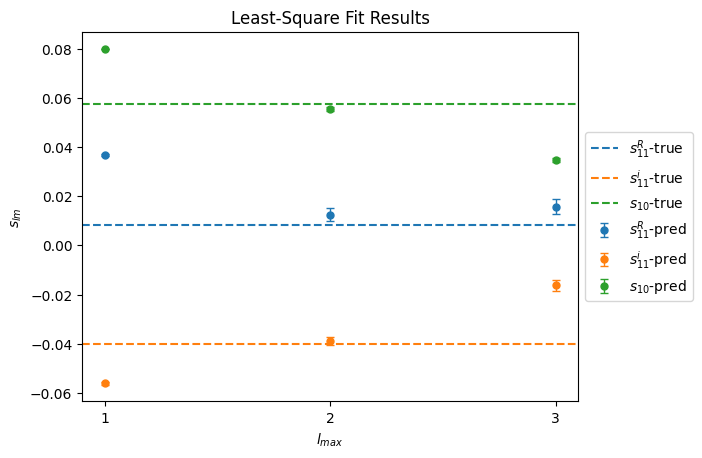

In [ ]:
import matplotlib.pyplot as plt

# HMC
lmax_values = [1,2,3]

s10_hmc, er10_hmc = [coef_pred[z][1] for z in range(0,3)], [std_pred[z][1] for z in range(0,3)]
s11r_hmc, er11r_hmc = [coef_pred[x][4] for x in range(0,3)], [std_pred[x][4] for x in range(0,3)]
s11i_hmc, er11i_hmc = [coef_pred[y][5] for y in range(0,3)], [std_pred[y][5] for y in range(0,3)]


plt.errorbar(lmax_values, s11r_hmc, yerr=er11r_hmc, fmt='o', capsize=3, markersize=5, elinewidth=1, label=r'$s_{11}^{R}$-pred')
plt.errorbar(lmax_values, s11i_hmc, yerr=er11i_hmc, fmt='o', capsize=3, markersize=5, elinewidth=1, label=r'$s_{11}^i$-pred')
plt.errorbar(lmax_values, s10_hmc, yerr=er10_hmc, fmt='o', capsize=3, markersize=5, elinewidth=1, label=r'$s_{10}$-pred')

plt.axhline(vsh_coeff_gen[4], linestyle='--', color='tab:blue', label=r'$s_{11}^{R}$-true')
plt.axhline(vsh_coeff_gen[5], linestyle='--', color='tab:orange', label=r'$s_{11}^{i}$-true')
plt.axhline(vsh_coeff_gen[1], linestyle='--', color='tab:green', label=r'$s_{10}$-true')

plt.title("HMC Sampling Results")
plt.xlabel(r'$l_{max}$')
plt.ylabel(r'$s_{lm}$')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(lmax_values)
#plt.savefig("plots/plots_test/hmc_on_fake_data.png", dpi=300, bbox_inches='tight')
plt.show()

# Least-Square

s10_ls, er10_ls = [fitted_thetas[z][1] for z in range(0,3)], [std_theta_fit[z][1] for z in range(0,3)]
s11r_ls, er11r_ls = [fitted_thetas[x][4] for x in range(0,3)], [std_theta_fit[x][4] for x in range(0,3)]
s11i_ls, er11i_ls = [fitted_thetas[y][5] for y in range(0,3)], [std_theta_fit[y][5] for y in range(0,3)]


plt.errorbar(lmax_values, s11r_ls, yerr=er11r_ls, fmt='o', capsize=3, markersize=5, elinewidth=1, label=r'$s_{11}^{R}$-pred')
plt.errorbar(lmax_values, s11i_ls, yerr=er11i_ls, fmt='o', capsize=3, markersize=5, elinewidth=1, label=r'$s_{11}^i$-pred')
plt.errorbar(lmax_values, s10_ls, yerr=er10_ls, fmt='o', capsize=3, markersize=5, elinewidth=1, label=r'$s_{10}$-pred')

plt.axhline(vsh_coeff_gen[4], linestyle='--', color='tab:blue', label=r'$s_{11}^{R}$-true')
plt.axhline(vsh_coeff_gen[5], linestyle='--', color='tab:orange', label=r'$s_{11}^{i}$-true')
plt.axhline(vsh_coeff_gen[1], linestyle='--', color='tab:green', label=r'$s_{10}$-true')

plt.title("Least-Square Fit Results")
plt.xlabel(r'$l_{max}$')
plt.ylabel(r'$s_{lm}$')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(lmax_values)
#plt.savefig("plots/plots_test/iminuit_on_fake_data.png", dpi=300, bbox_inches='tight')
plt.show()

## Code up a different vesion of the least_square function by coding the full expansion instead

In [2]:
import jax 
import jax.numpy as jnp
import numpy as np
from src.models.vsh_model import*
import pandas as pd
from iminuit import Minuit # to perform least square
from src.models.configuration import*
from numpyro.infer import MCMC, NUTS
import numpyro
from src.data.data_utils import*
import numpyro.distributions as dist
from tqdm import tqdm
import gc
from numpyro.diagnostics import summary

/root/Document/Gaia_Project/mem97/src/models/vsh_model.py:93: SyntaxWarning: invalid escape sequence '\d'
  """
/root/Document/Gaia_Project/mem97/src/models/vsh_model.py:144: SyntaxWarning: invalid escape sequence '\d'
  """
/root/Document/Gaia_Project/mem97/src/models/vsh_model.py:203: SyntaxWarning: invalid escape sequence '\d'
  """
/root/Document/Gaia_Project/mem97/gaia_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = load_qso_dataframe() # load full dataset for 5 param solution
angles, obs, error = config_data(df)

In [3]:
@partial(jit, static_argnames=['lmax', 'grid'])
def least_square0(angles, obs, error, theta, lmax, grid):


    alpha, delta = angles
    mu_a_obs, mu_d_obs = obs
    s_mu_a, s_mu_d, rho = error

    def per_point(alpha_i, delta_i, mu_a_i, mu_d_i, s_a, s_d, r):
        e_a, e_d = basis_vectors(alpha_i, delta_i)

        V = model_vsh(alpha_i, delta_i, theta, lmax=lmax, grid=grid)
        V_alpha = jnp.vdot(V, e_a).real
        V_delta = jnp.vdot(V, e_d).real

        d_alpha = mu_a_i - V_alpha
        d_delta = mu_d_i - V_delta

        norm_alpha = d_alpha / s_a
        norm_delta = d_delta / s_d

        X2 = (norm_alpha**2 - 2*r*norm_alpha*norm_delta + norm_delta**2) / (1 - r**2)
        return X2

    batched_fn = vmap(per_point)
    losses = batched_fn(alpha, delta, mu_a_obs, mu_d_obs, s_mu_a, s_mu_d, rho)
    return jnp.sum(losses)

In [4]:
error

array([[ 1.55250692,  1.48242414,  0.257395  , ...,  0.34734339,
         2.02866316,  0.40030757],
       [ 1.22625899,  1.40200174,  0.22310686, ...,  0.24736069,
         0.94757712,  0.29778305],
       [ 0.20776933,  0.28530309,  0.16432883, ...,  0.2512258 ,
        -0.11815098,  0.22144131]], shape=(3, 1215942))

In [ ]:
def chi2_jit(angles, obs, error, theta, lmax):
    return least_square(angles, obs, error, theta, lmax=lmax, grid=False)
chi2_jit = jit(chi2_jit, static_argnames=['lmax'])


def model_w_uni_prior(angles, obs, error, 
                      limit = 0.1, lmax = 3):
    total_params = count_vsh_coeffs(lmax)
    # Prior on all VSH coefficients (both toroidal and spheroidal)
    theta = numpyro.sample("theta", dist.Uniform(-limit, limit).expand([total_params]))
    # Least-squares residuals: we assume Gaussian-distributed residuals
    chi2_val = chi2_jit(angles, obs, error, theta, lmax=lmax)

    # The log-likelihood is proportional to -0.5*chi^2
    numpyro.factor("likelihood", -0.5*chi2_val)

In [5]:
n_s = 1000 # number of samples
n_warmup = 2000 #  number of warmups 
n_chains = 2 # numbe of chains

In [7]:
x = np.random.randint(1, 101)
rng_key = jax.random.key(x)

kernel_uni = NUTS(model_w_uni_prior, target_accept_prob=0.75) # this is to make sure acceptance does not exceed 90%
mcmc_uni = MCMC(kernel_uni, num_warmup=n_warmup, num_samples=n_s, num_chains=n_chains, progress_bar=True)
mcmc_uni.run(rng_key, angles = angles, obs = obs, error = error, limit = 1, lmax=3)
ps_w_uni_prior = mcmc_uni.get_samples()
diagnostics = summary(mcmc_uni.get_samples(group_by_chain=True))
divergences = mcmc_uni.get_extra_fields()["diverging"]  # shape: (num_samples * num_chains,)
num_divergences = divergences.sum()
print("Number of divergences:", num_divergences)
del mcmc_uni

/tmp/ipykernel_2614/979775106.py:5: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc_uni = MCMC(kernel_uni, num_warmup=n_warmup, num_samples=n_s, num_chains=n_chains, progress_bar=True)
sample: 100%|██████████| 3000/3000 [01:59<00:00, 25.07it/s, 7 steps of size 3.90e-01. acc. prob=0.84] 


Number of divergences: 0


In [8]:
coeff_est_uni = jnp.mean(ps_w_uni_prior['theta'], axis = 0)
std_coeff_uni = jnp.std(ps_w_uni_prior['theta'], axis = 0)
spheroidal_vector_summary(coeff_est_uni, std_coeff_uni**2)

Equatorial components:
G_vec = [-0.5495685 -8.178594  -2.839235 ] +/- [0.7191543  0.6664866  0.31583044](μas/yr)
Magnitude = 8.674830436706543 +/- 1.3236701488494873 (μas/yr)
RA = 266.1557312011719 +/- 10.284764289855957 (deg)
Dec = -19.104719161987305 +/- 0.2183869481086731 (deg)

Galactic components:
G_vec = [8.54736623 1.24567559 0.80218294] +/- [0.60314875 0.51944348 0.65385493](μas/yr)
l = 8.291793332542582 +/- 3.458055223784402 (deg)
d = 5.305862308958555 +/- 0.3664185836100438 (deg)


In [1]:
import jax 
import jax.numpy as jnp
import numpy as np
from src.models.vsh_model import*
import pandas as pd
from iminuit import Minuit # to perform least square
from src.models.configuration import*
from src.data.data_utils import*
from tqdm import tqdm
import gc

/root/Document/Gaia_Project/mem97/src/models/vsh_model.py:93: SyntaxWarning: invalid escape sequence '\d'
  """
/root/Document/Gaia_Project/mem97/src/models/vsh_model.py:144: SyntaxWarning: invalid escape sequence '\d'
  """
/root/Document/Gaia_Project/mem97/src/models/vsh_model.py:203: SyntaxWarning: invalid escape sequence '\d'
  """
/root/Document/Gaia_Project/mem97/gaia_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = load_qso_dataframe() # load full dataset for 5 param solution
angles, obs, error = config_data(df)

In [3]:
lmax = 3
total_params = count_vsh_coeffs(lmax) 
#limits = vsh_minuit_limits(lmax=lmax, t_bound=0.05, s_bound=0.01)

# Flat vector theta: [t10, ..., t_lmaxm, s10, ..., s_lmaxm]
theta_init = jnp.zeros(total_params)

# Fix everything except theta
#bound_least_square = partial(least_square, data, obs, error, lmax=lmax, grid=False)

def least_square_wrapper(*theta_flat):
    theta = jnp.array(theta_flat)  # reconstructs the vector from scalars
    return least_square(angles, obs, error, theta, lmax=lmax, grid=False)


m = Minuit(least_square_wrapper, *theta_init)

m.errordef = Minuit.LEAST_SQUARES

m.migrad()
print(m.params)
print('Converged to miminum?', m.fmin.is_valid)

┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │-2.7875e-4 │    nan    │            │            │         │         │       │
│ 1 │ x1   │-8.2877e-3 │    nan    │            │            │         │         │       │
│ 2 │ x2   │-5.6495e-3 │    nan    │            │            │         │         │       │
│ 3 │ x3   │ 3.6565e-3 │    nan    │            │            │         │         │       │
│ 4 │ x4   │ 6.0079e-4 │    nan    │            │            │         │         │       │
│ 5 │ x5   │-8.3748e-3 │    nan    │            │            │         │         │       │
│ 6 │ x6   │ 4.6631e-3 │    nan    │            │            │         │         │       │
│ 7 │ x7   │-4.4139e-3 │    nan    │            │            │         │         │       │

In [4]:
parameters = jnp.array([m.values[k] for k in m.parameters])
hessian_matrix = m.covariance
variances = jnp.diag(hessian_matrix)
spheroidal_vector_summary(parameters, variances)

Equatorial components:
G_vec = [-0.29354855 -4.0919294  -2.8633513 ] +/- [nan nan nan](μas/yr)
Magnitude = 5.002883434295654 +/- nan (μas/yr)
RA = 265.8966979980469 +/- nan (deg)
Dec = -34.91357421875 +/- nan (deg)

Galactic components:
G_vec = [ 4.97554136 -0.46370611 -0.24042498] +/- [nan nan nan](μas/yr)
l = 354.6755784075984 +/- nan (deg)
d = -2.7545404725291918 +/- nan (deg)
